In [130]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product

In [136]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':(('popsize',), ('seed', 'sigma')),
	'pso':(('popsize', 'w'), ('seed', 'c1', 'c2')),
	'bo-ucb':(('kappa',), ('seed',)),
	'bo-ei': (('xi',), ('seed',)),
	'bo-poi': (('xi',), ('seed',))
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
['pso', 'cma', 'bo']


In [133]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 112 if MACHINE in 'ruby' else 160
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'threads')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

       progname probsize       xtime
0        bt_nas  lrgprob  745.260000
1        bt_nas  medprob   31.943333
2        bt_nas  smlprob    7.383333
3   cfd_rodinia  lrgprob    9.222637
4   cfd_rodinia  medprob    4.186460
5   cfd_rodinia  smlprob    1.578907
6        cg_nas  lrgprob  176.373333
7        cg_nas  medprob    4.796667
8        cg_nas  smlprob    1.143333
9        ft_nas  lrgprob  138.460000
10       ft_nas  medprob    3.903333
11       ft_nas  smlprob    0.940000
12         hpcg  lrgprob   65.220033
13         hpcg  medprob   17.178033
14         hpcg  smlprob    1.949250
15       lulesh  lrgprob   18.396099
16       lulesh  medprob    9.995197
17       lulesh  smlprob    4.854440


In [134]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'],
      dtype='object')
c1 [0.1  0.45 0.8  1.15 1.5   nan]
c2 [0.1  0.45 0.8  1.15 1.5   nan]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['pso' 'cma' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [18.  3. 21.  6. 24.  9. 27. 12. 30. 15. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [   nan  1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778
 30.   ]
w [0.1   0.325 0.55  0.775 1.      nan]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


In [157]:
def makeGOHyperHeatmapPlots(df, method):

	# we're going to make one plot for each GO method
	# want to show programs in rows, probsize in columns
	# the heatmap for each will show the hyperparameters on the two axes
	
	# we're going to generate 4 heatmaps showing the following values:
	# 1) the earliest step a better-than-baseline configuration found
	# 2) the speedup of the best configuration found after 100 steps
	# 3) the speedup of the best configuration found after 200 steps
	# 4) the speedup of the best configuration found after 300 steps
	
	# get the subset we're interested in
	df = df[df['method'] == method].reset_index(drop=True)
	
	#print(df.columns)
	
	xaxis, yaxis = hypers[method]
	#print(xaxis, yaxis)
	
	axisCols = list(xaxis+yaxis)
	axisCols.remove('seed')
	colsToKeep = ['progname', 'probsize', 'seed', 'globalSample']+axisCols
	colsToDrop = list(df.columns)
	
	[colsToDrop.remove(col) for col in colsToKeep]
	colsToDrop.remove('xtime')
	
	#print('dropping')
	#print(colsToDrop)
	
	# get rid of unused columns
	df = df.drop(colsToDrop, axis=1)
	
	# presort the DF
	df = df.sort_values(by=colsToKeep, ignore_index=True)
	
	# pick one combination to make column tuples with
	subset = df[(df['progname'] == prognames[0]) & (df['probsize'] == probsizes[0]) & (df['seed'] == seeds[0]) & (df['globalSample'] == 0)]
	#print('subset cols', subset.columns)
	#print('subset shape',subset.shape)
	
	
	
	# need to make tuples of the columns, and stringify them
	if len(xaxis) > 1:
		xtuples = list(product(*[list(sorted(subset[col].unique())) for col in xaxis]))
		#tuples = list(set([ str(a) for a in list(zip( *[list(subset[col]) for col in xaxis] ))]))
		#print(len(xtuples), xtuples)
	
		# tupleify the columns and drop them
		newXColName = f'({",".join(xaxis)})'
		df[newXColName] = list(zip(*[df[col] for col in xaxis]))
		df = df.drop(list(xaxis), axis=1)
	else:
		xtuples = list(sorted(subset[xaxis[0]].unique()))
		newXColName = xaxis[0]
		#print(xtuples)
	
	if len(yaxis) > 1:
		ytuples = list(product(*[list(sorted(subset[col].unique())) for col in yaxis]))
		#tuples = list(set([ str(a) for a in list(zip( *[list(subset[col]) for col in xaxis] ))]))
		#print(len(ytuples), ytuples)
	
		# tupleify the columns and drop them
		newYColName = f'({",".join(yaxis)})'
		df[newYColName] = list(zip(*[df[col] for col in yaxis]))
		df = df.drop(list(yaxis), axis=1)
	else:
		ytuples = list(sorted(subset[yaxis[0]].unique()))
		newYColName = yaxis[0]
		#print(ytuples)
	
	#print('new columns')
	#print(df.columns)
	
	#print('uniques')
	## for each column, print the number of unique values
	#for col in list(df.columns):
	#	if col != 'xtime':
	#		print(col, len(list(df[col].unique())))
	
	# find the min xtime found up to each globalSample
	df['cummin'] = df.groupby([newXColName, newYColName, 'probsize', 'progname'])['xtime'].transform('cummin')
	
	# let's make a new dataframe column for each plot type we want to make
	# 1) earliest better-than-baseline config found for each GO hyperparam combination
	
	# rescale the xtime to be baseline-normalized
	#print('pre-reset index')
	#print(df.shape, df.head())
	df = df.set_index(['progname', 'probsize', newXColName, newYColName])
	baselines = globalBaselines.set_index(['progname', 'probsize'])
	#print('post- reset index')
	#print(df.shape, df.head())
	
	df['baselineXtime'] = 1/df['cummin'].div(baselines.reindex(df.index)['xtime'], axis=0)
	
	#print('rescaled')
	#print(df.shape, df.head())
	
	earliestSamples = pd.DataFrame(index=df.index.copy())
	#earliestSamples = df.copy(deep=True)
	#print('super init earliest sampels')
	#print(earliestSamples.shape, earliestSamples)
	earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
	#earliestSamples = earliestSamples.groupby(earliestSamples.index).first()
	
	# set it to the latest possible value
	earliestSamples['firstSample'] = 301
	
	#print('init early samples')
	#print(earliestSamples.shape, earliestSamples)
	
	#test = df.loc[df.baselineXtime >= 0.1, 'globalSample'].min()
	test = df.loc[df.baselineXtime >= 1.0].groupby(level=[0,1,2,3])['globalSample'].min()
	#print('found earliest')
	#print(test.shape, test)
	
	# now find the earliest globalSample that is >= 1.0
	# update only a couple elements
	earliestSamples['firstSample'].update(test)
	#print('earliest samples')
	#print(earliestSamples.shape, earliestSamples)
	
	# now reset the index
	earliestSamples = earliestSamples.reset_index()
	
	#print('reset index')
	#print(earliestSamples.shape, earliestSamples)
	
	
	def drawHeatmap(*args, **kwargs):
		data = kwargs.pop('data').copy(deep=True)
		if 'probsize' in list(data.columns):
			data = data.drop(['probsize'], axis=1)
		if 'progname' in list(data.columns):
			data = data.drop(['progname'], axis=1)
		data = data.pivot(index=newXColName, columns=newYColName, values='firstSample')
		# silly how we have to resort this manually...
		#data.index = pd.CategoricalIndex(data.index, categories=uniqA)
		#data.sort_index(level=0, inplace=True)
	
		#data.columns = pd.CategoricalIndex(data.columns, categories=uniqB)
		#data.sort_index(axis='columns', level='OMP_NUM_THREADS_PLACES', inplace=True)
	
		#print(data)
		# plot the good values
		ax = sns.heatmap(data, **kwargs)
		return
	#
	#
	# let's first make the tuples of columns
	#
	g = sns.FacetGrid(earliestSamples, row='progname', col='probsize', col_order=probsizes, palette='flare', height=10, aspect=1.5)
	#g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)
	g.map_dataframe(drawHeatmap, annot=False, vmin=0, vmax=300, cbar=True, xticklabels=True, yticklabels=True)
	#
	#
	for ax in g.axes.flatten():
		ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
	#
	plt.tight_layout()
	#
	g.fig.subplots_adjust(top=0.96)
	g.fig.suptitle(f'GO Hyperparam Exploration ({method.upper()}) -- Samples till >= baseline xtime')
	#
	plt.show()
	#
	
	return

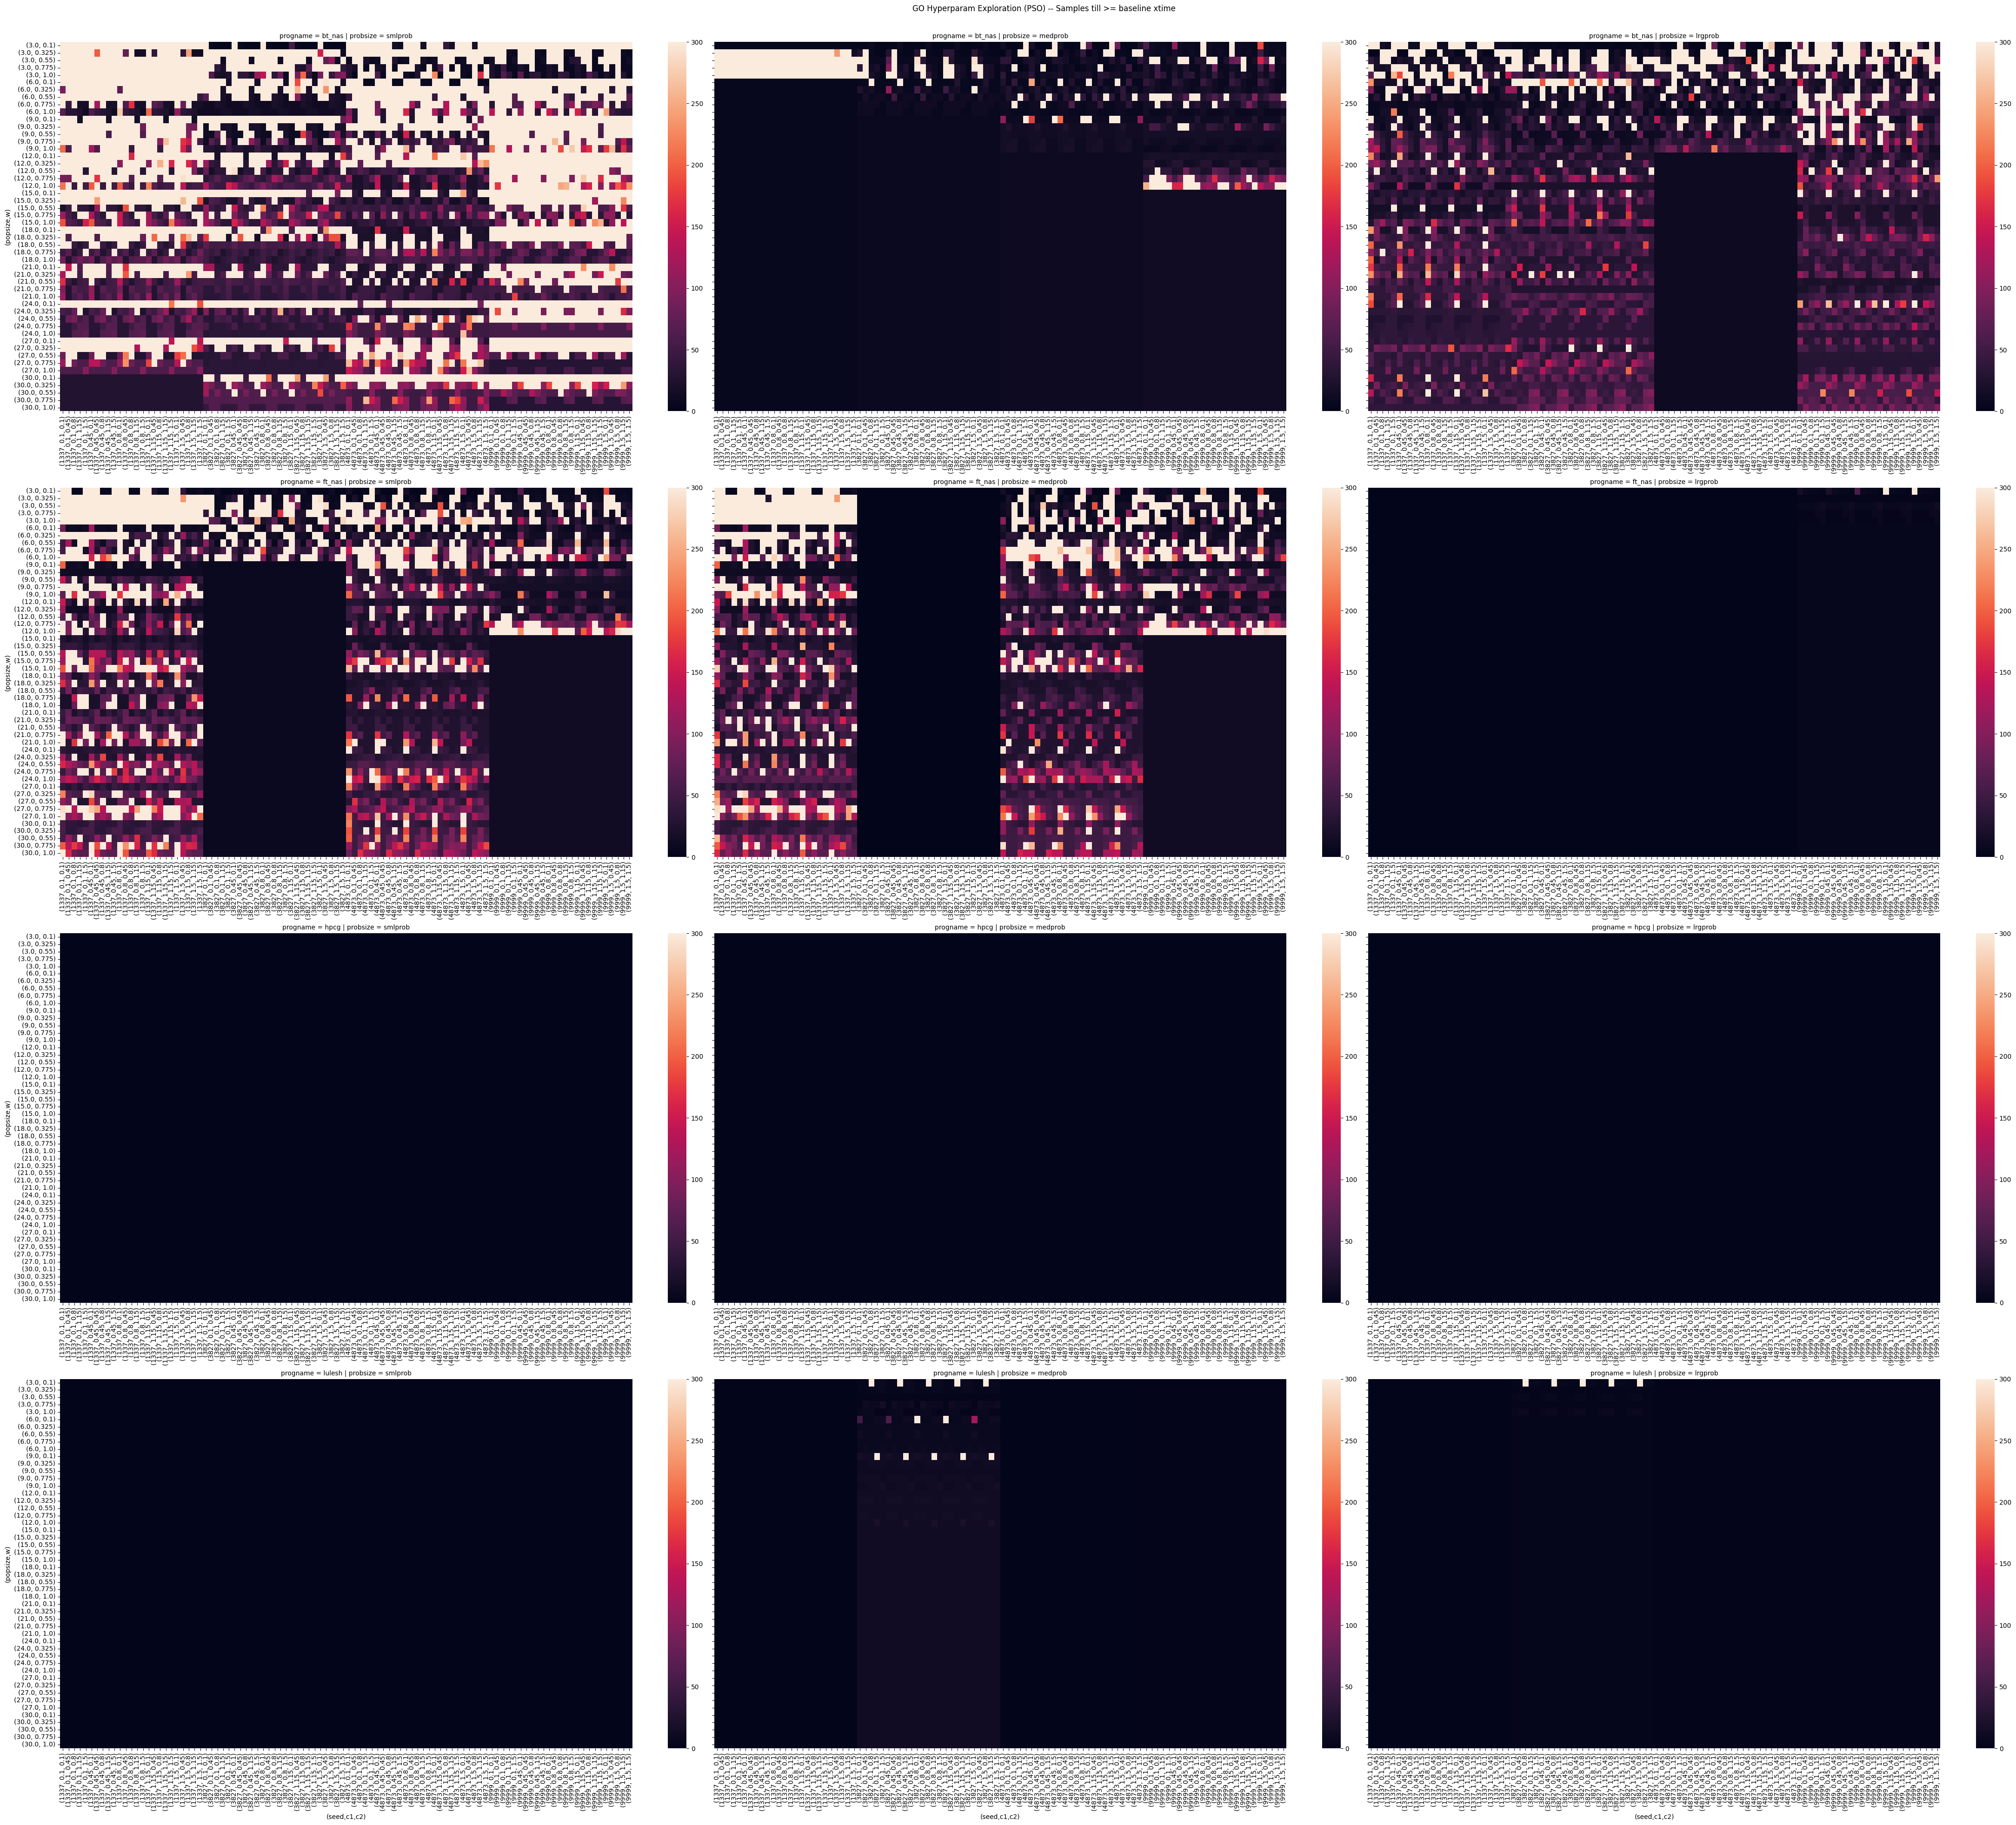

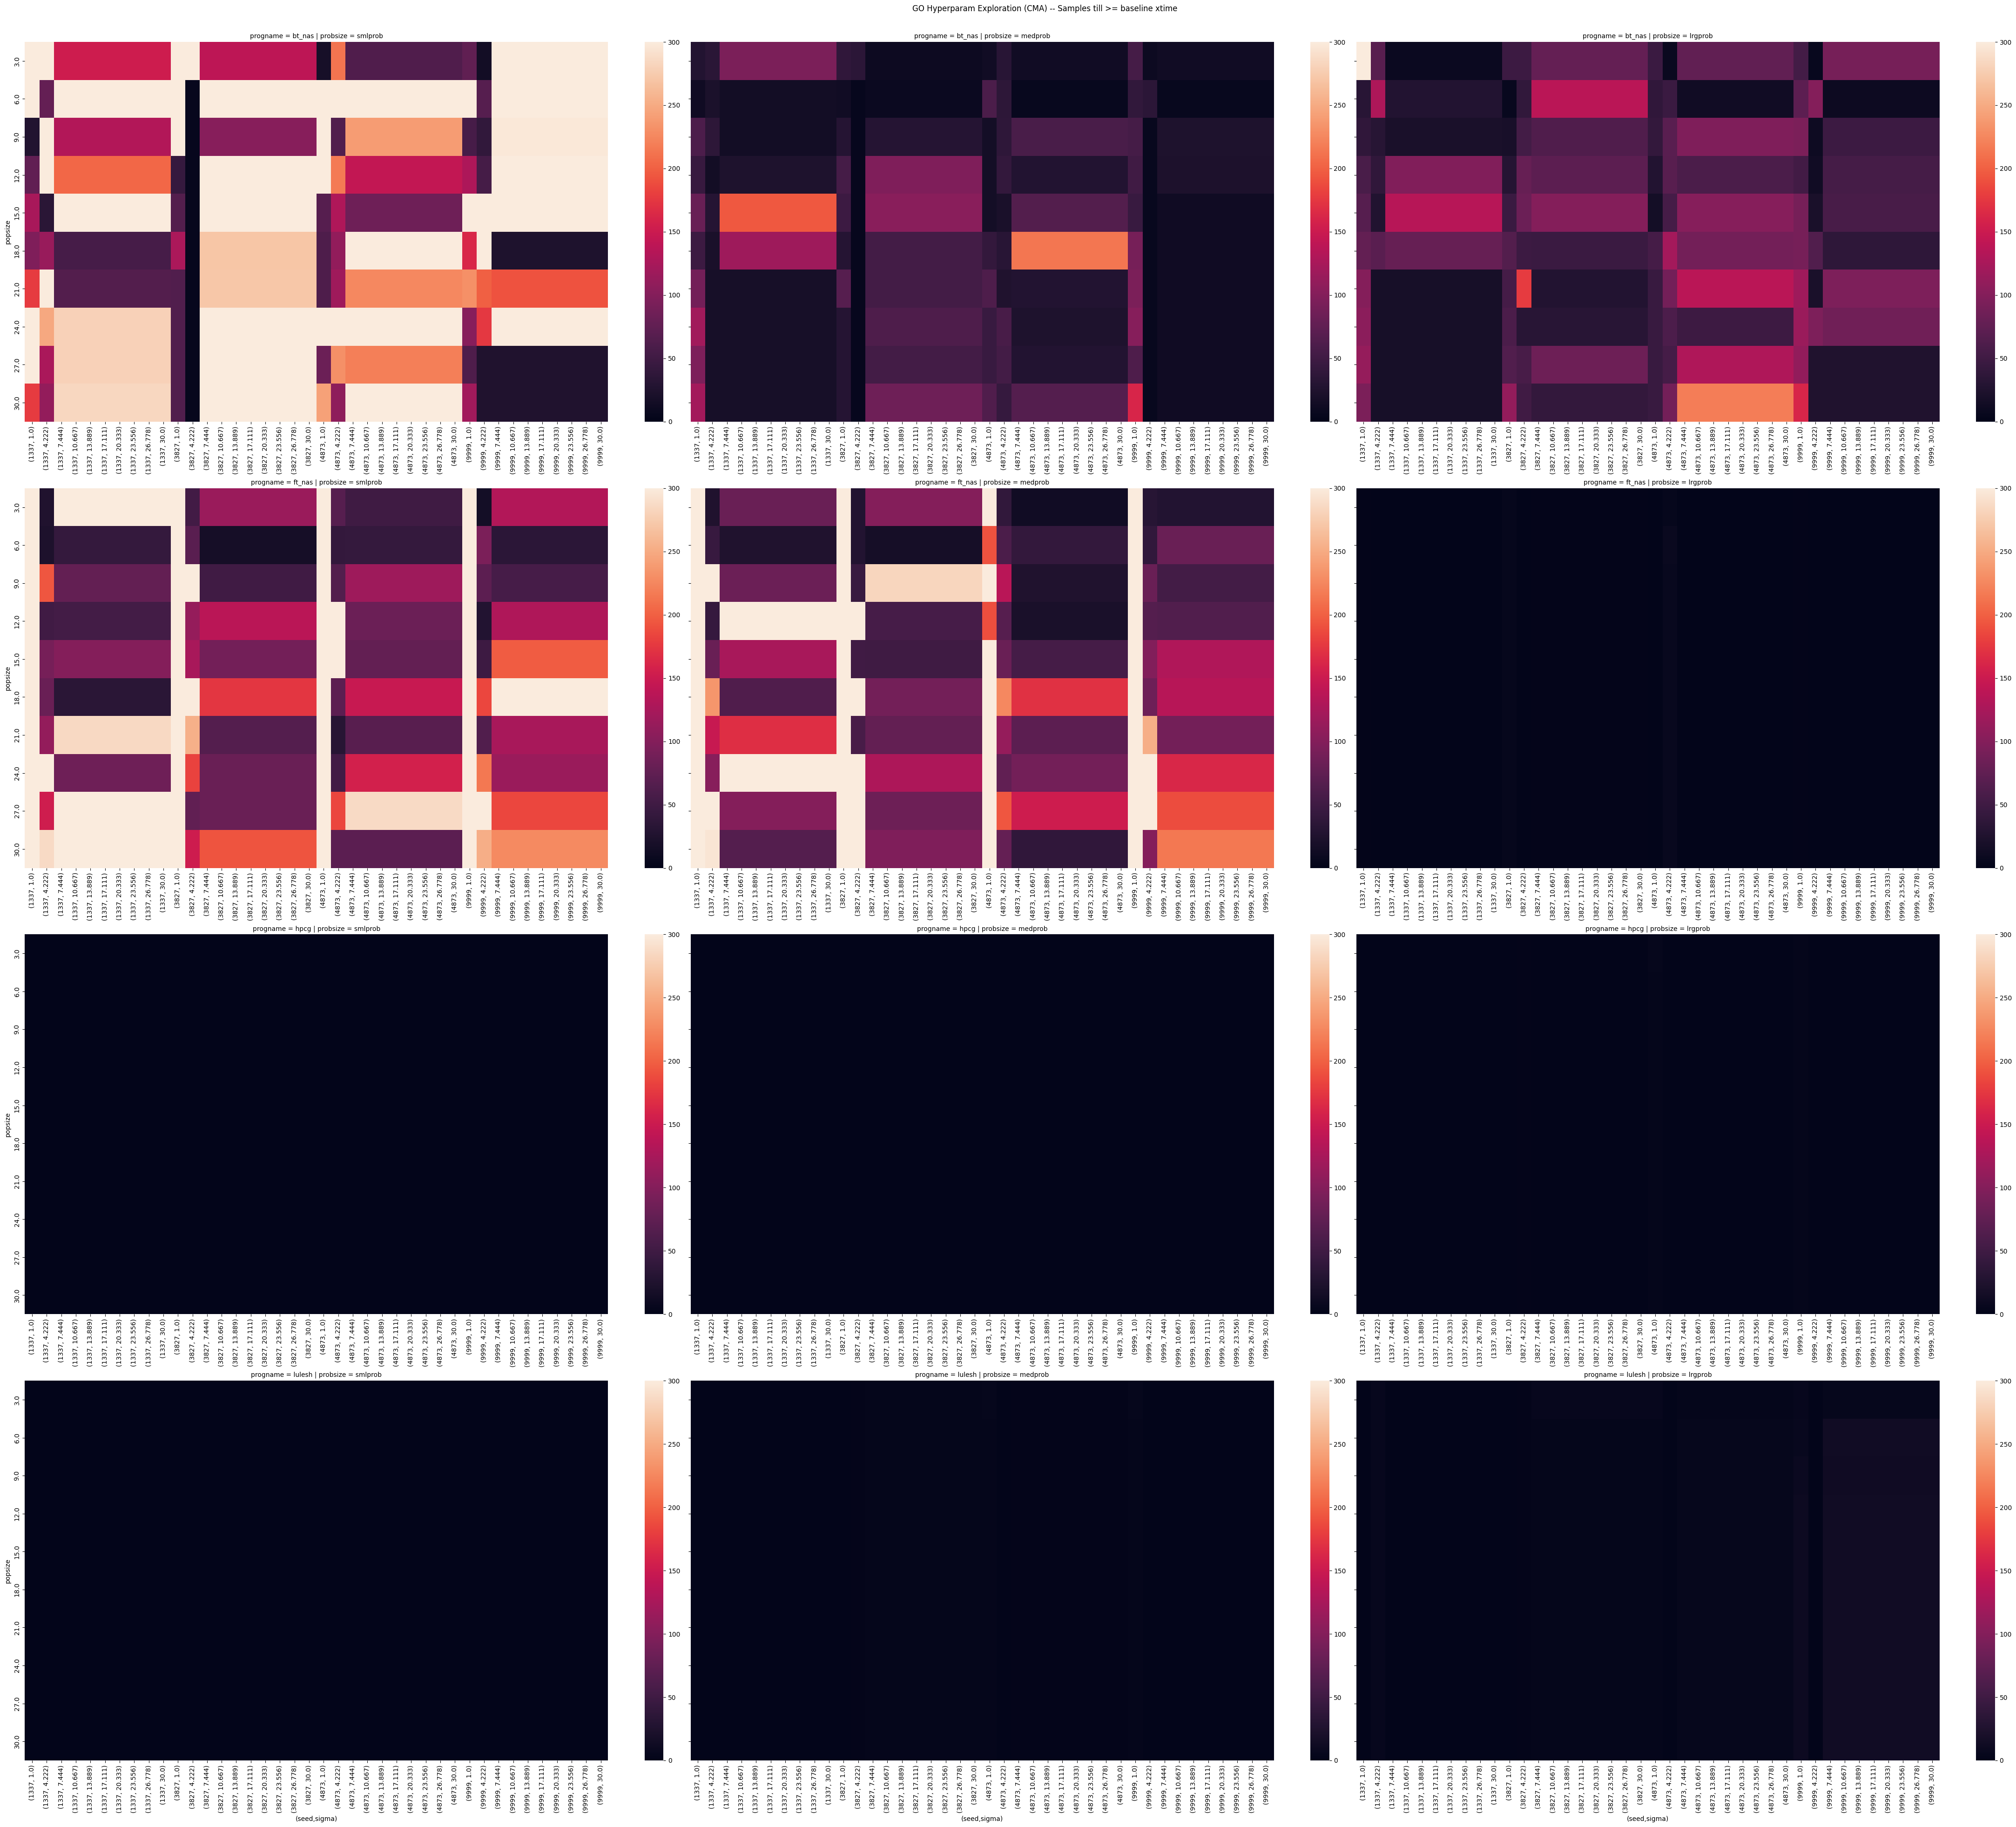

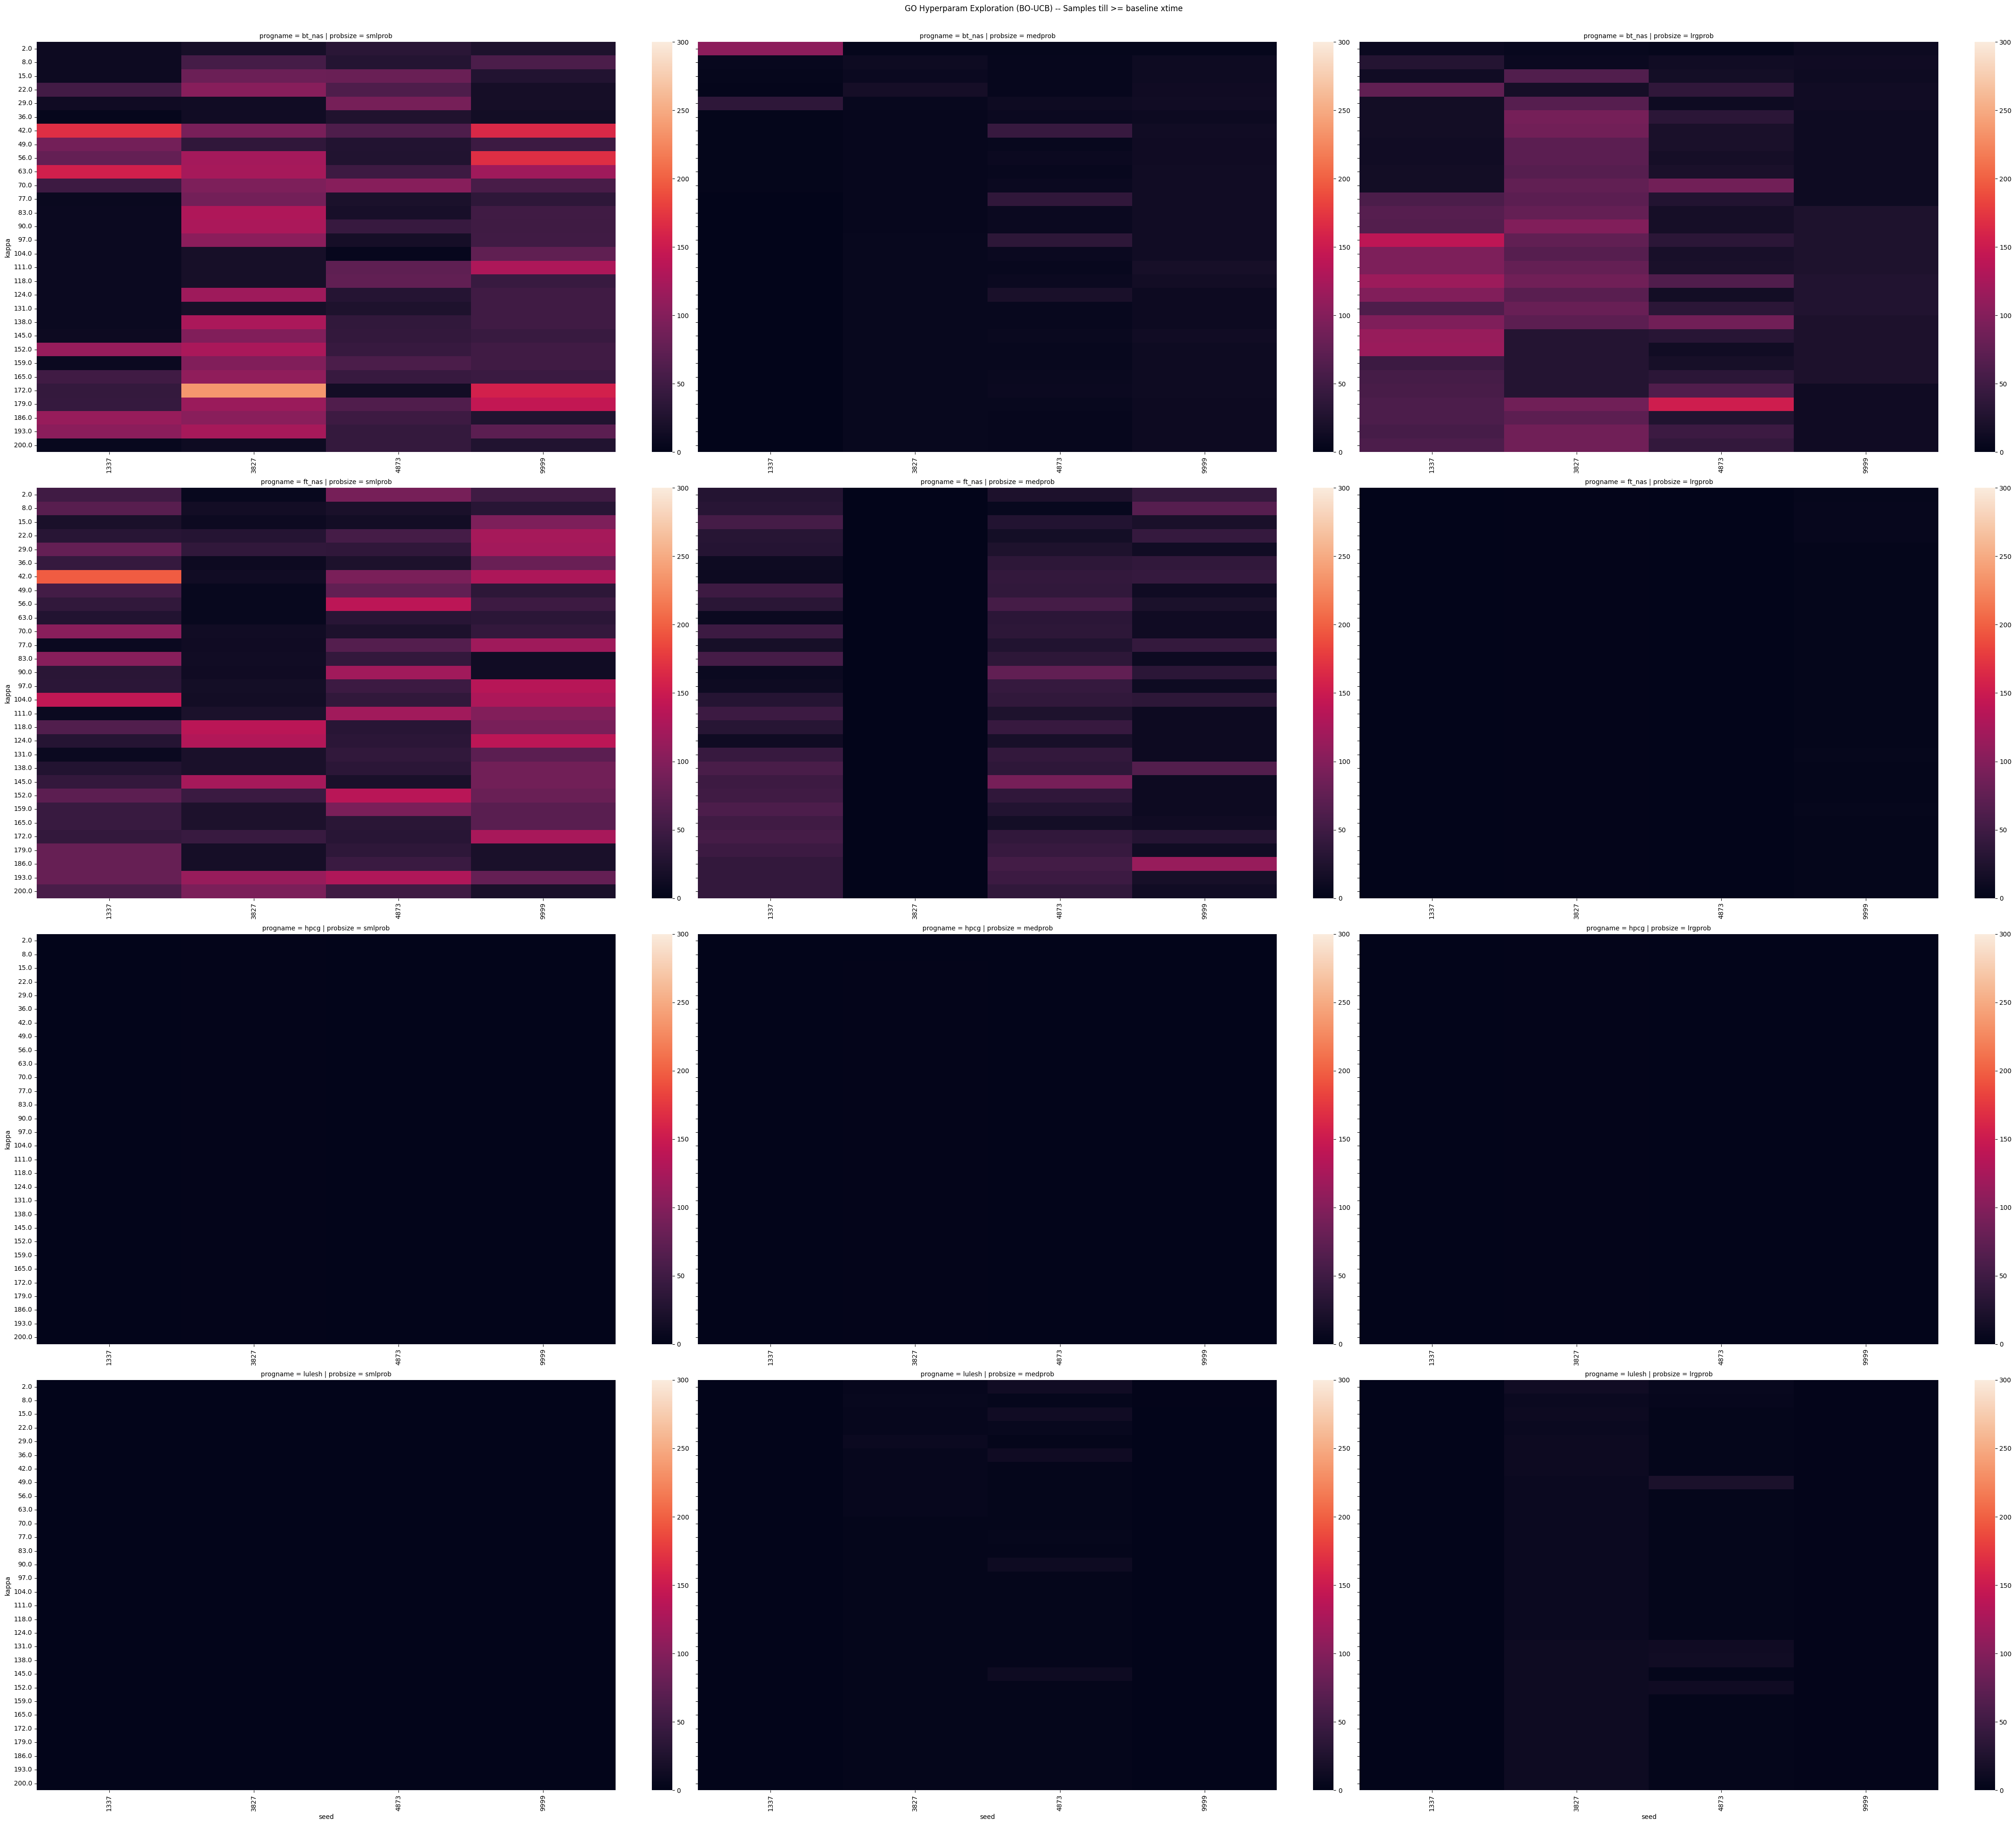

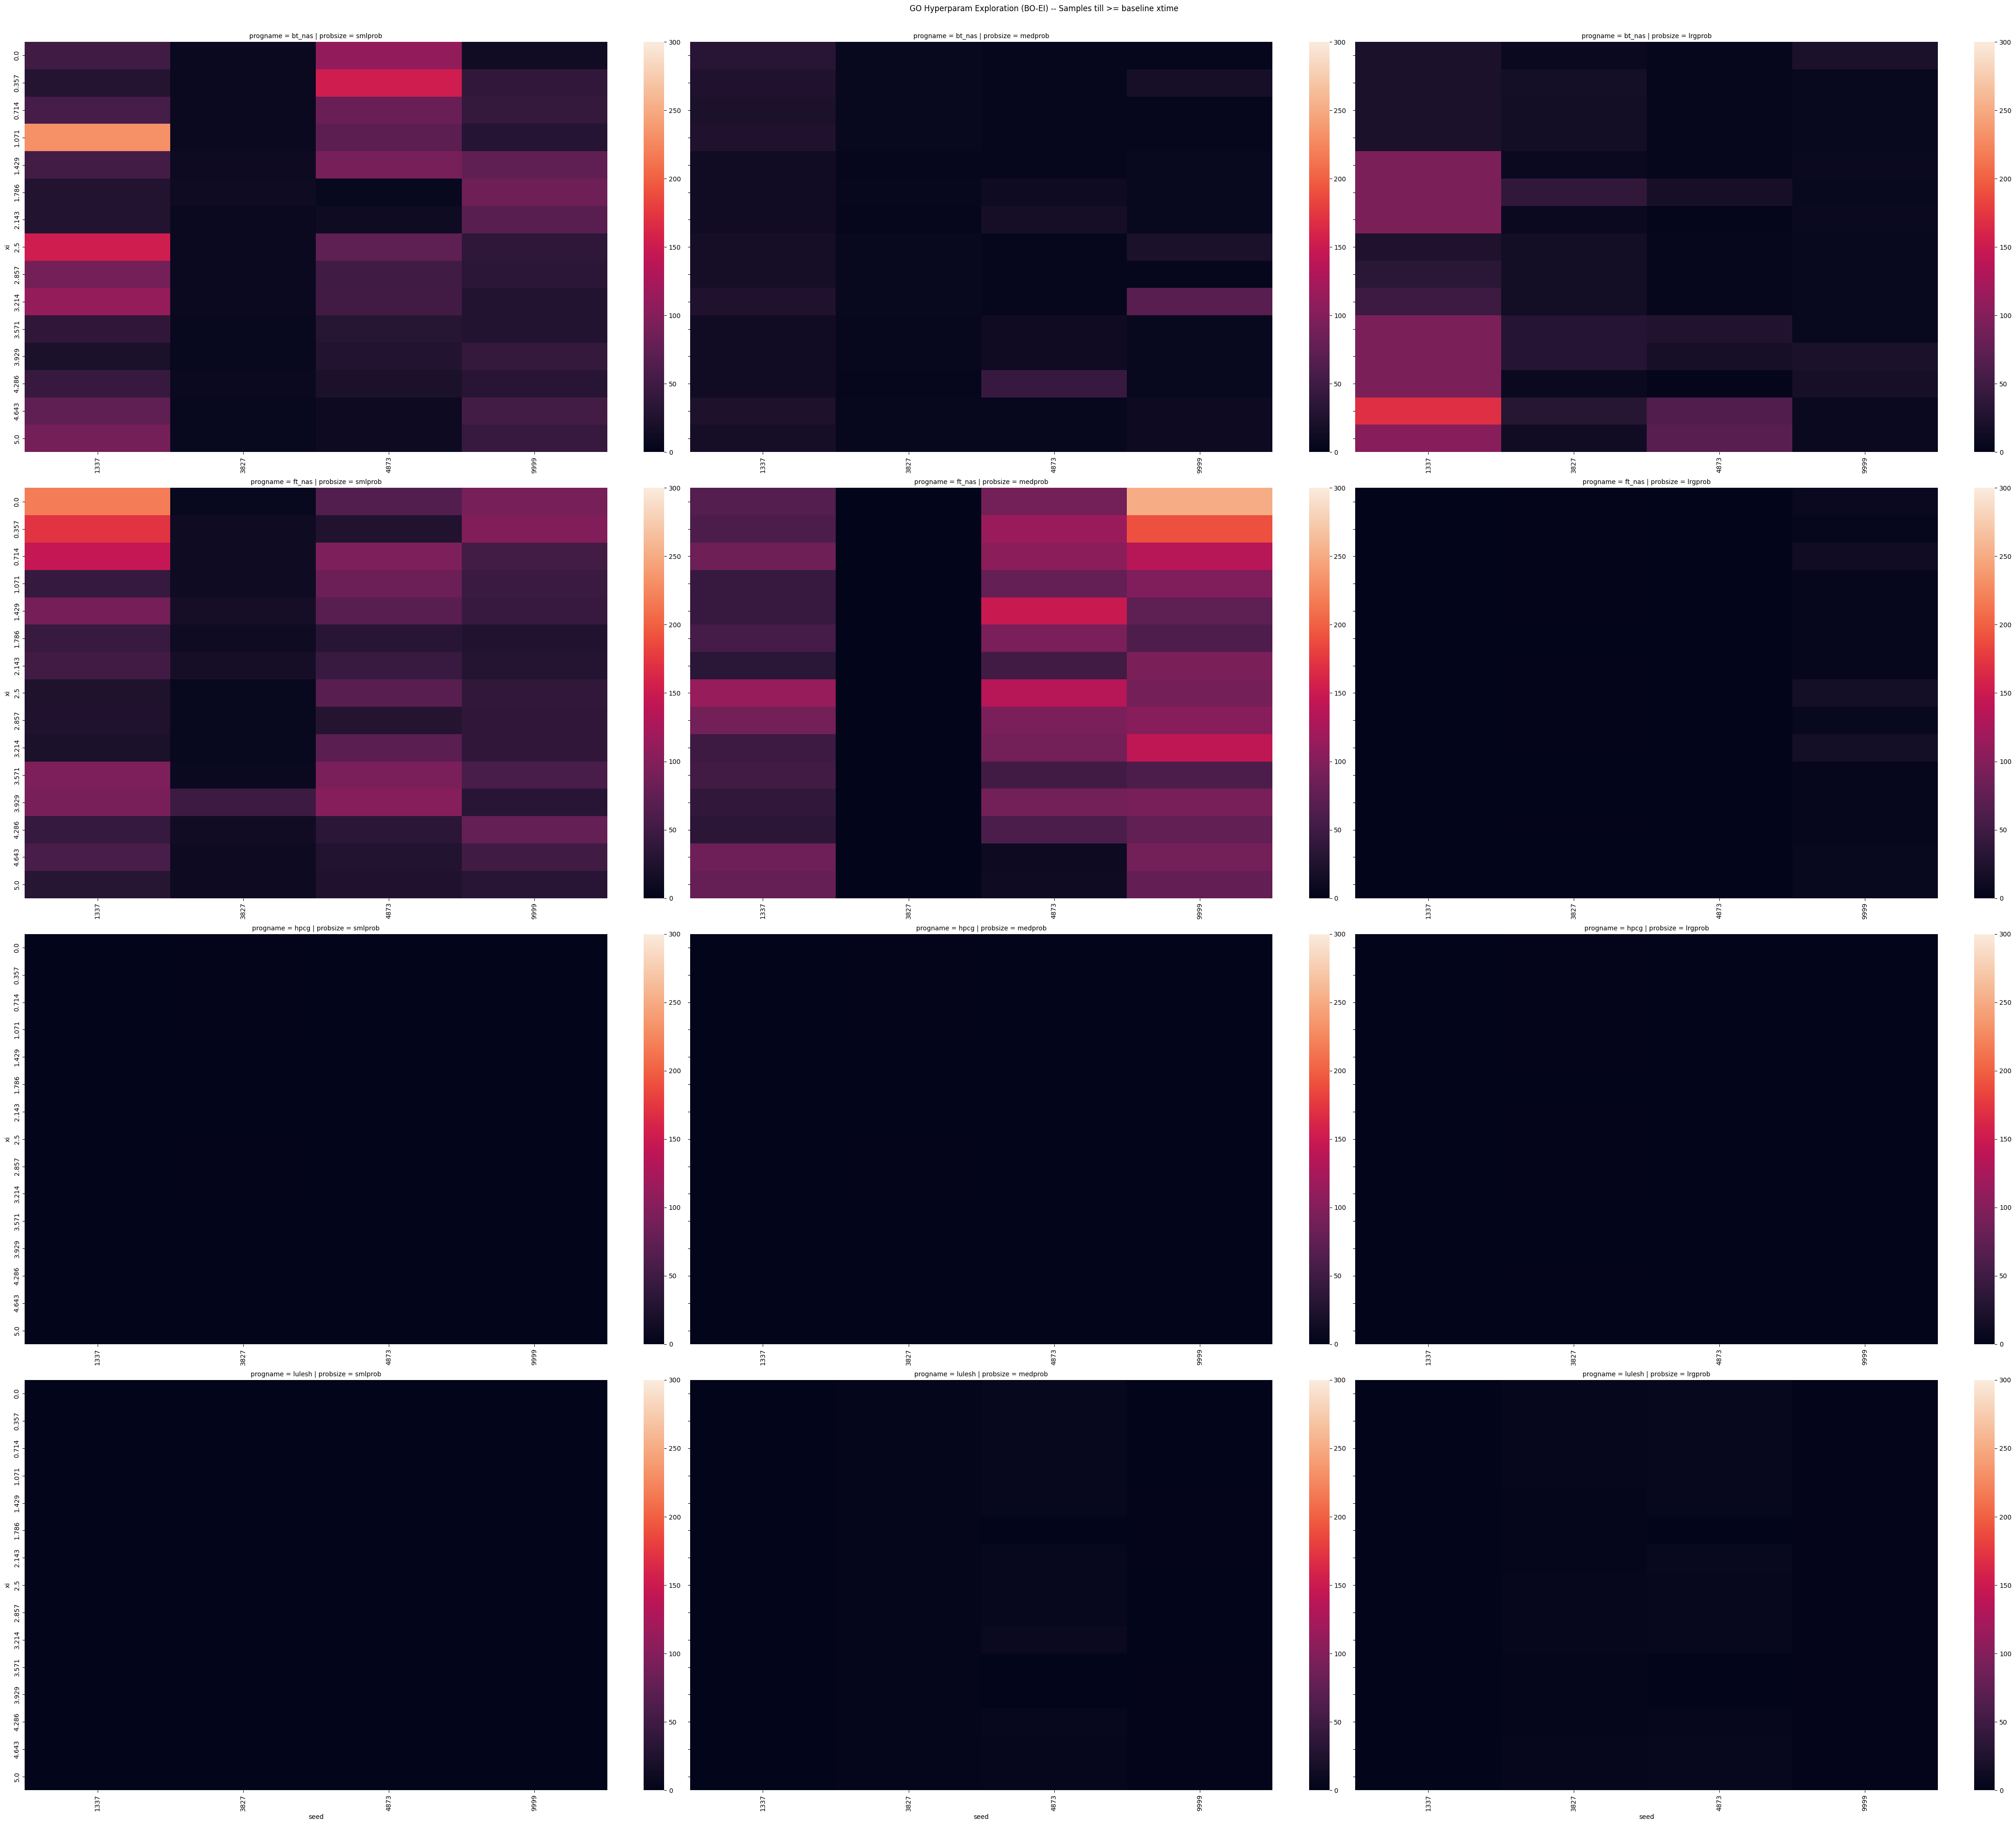

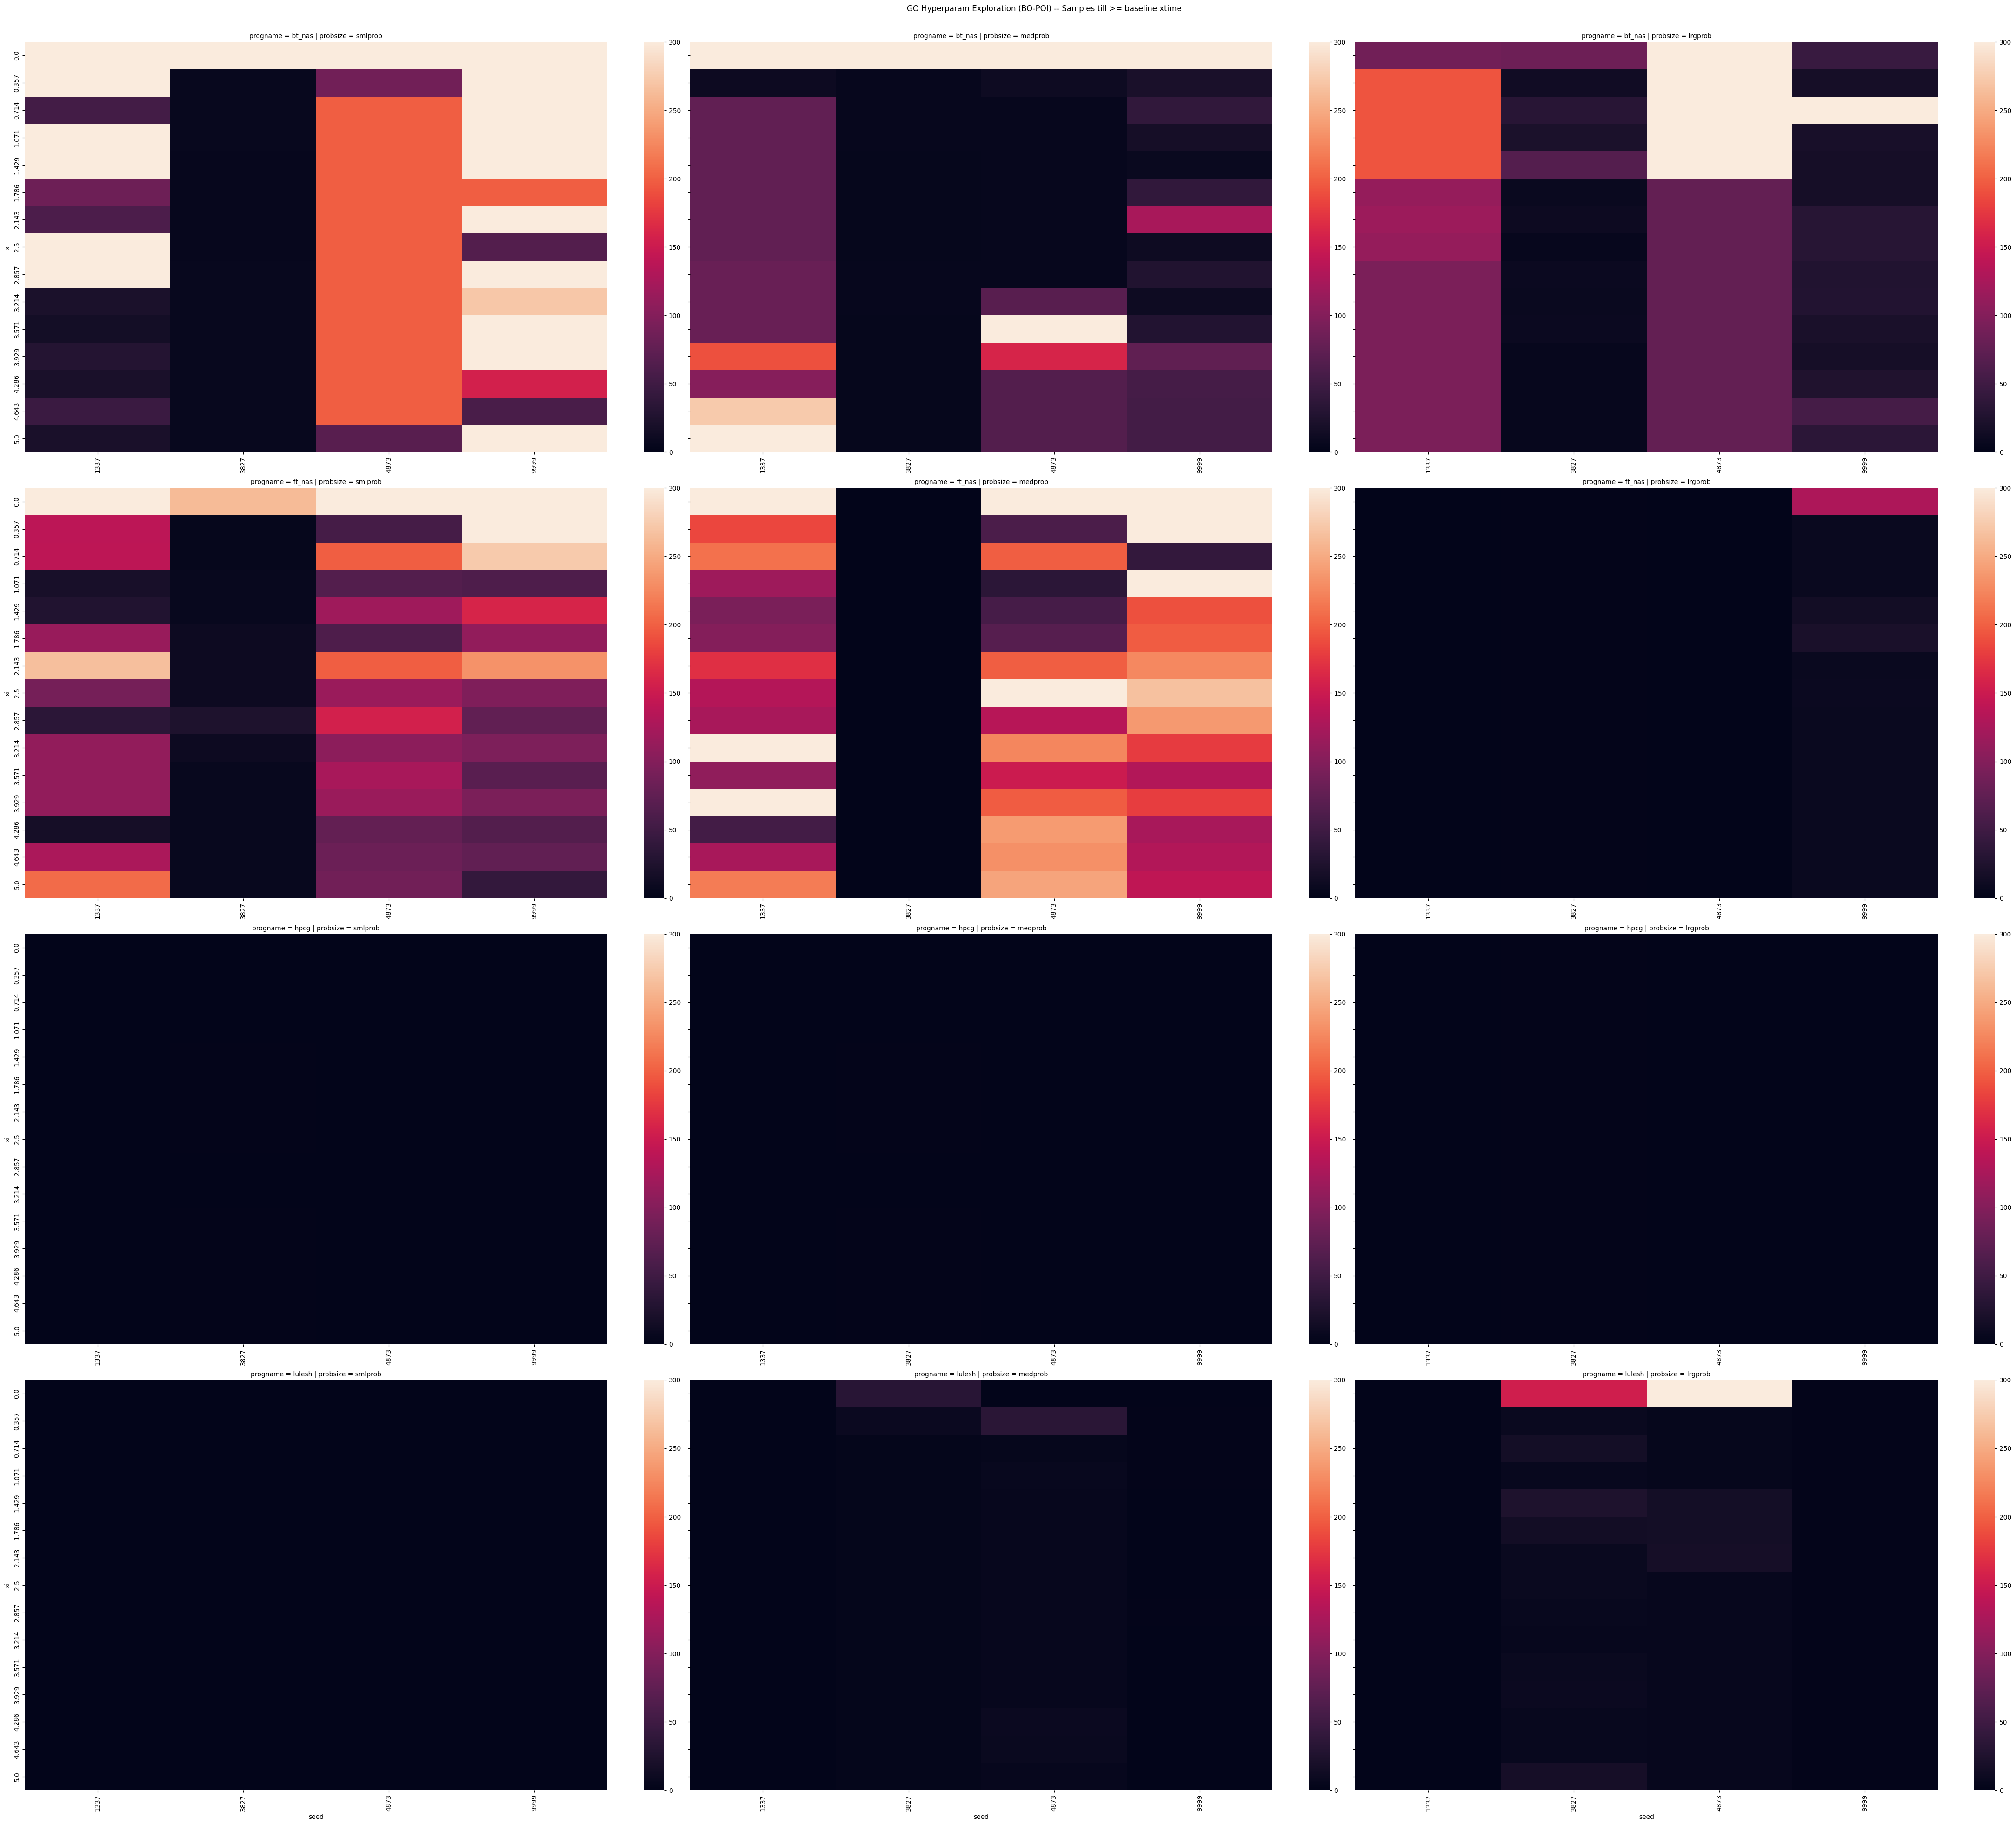

In [158]:
makeGOHyperHeatmapPlots(overallDF, 'pso')
makeGOHyperHeatmapPlots(overallDF, 'cma')
makeGOHyperHeatmapPlots(overallDF, 'bo-ucb')
makeGOHyperHeatmapPlots(overallDF, 'bo-ei')
makeGOHyperHeatmapPlots(overallDF, 'bo-poi')

In [145]:
## we're going to make one plot for each GO method
## want to show programs in rows, probsize in columns
## the heatmap for each will show the hyperparameters on the two axes
#
## we're going to generate 4 heatmaps showing the following values:
## 1) the earliest step a better-than-baseline configuration found
## 2) the speedup of the best configuration found after 100 steps
## 3) the speedup of the best configuration found after 200 steps
## 4) the speedup of the best configuration found after 300 steps
#
## get the subset we're interested in
#method = 'bo-ucb'
#df = overallDF[overallDF['method'] == method].reset_index(drop=True)
#
#print(df.columns)
#
#xaxis, yaxis = hypers[method]
#print(xaxis, yaxis)
#
#axisCols = list(xaxis+yaxis)
#axisCols.remove('seed')
#colsToKeep = ['progname', 'probsize', 'seed', 'globalSample']+axisCols
#colsToDrop = list(df.columns)
#
#[colsToDrop.remove(col) for col in colsToKeep]
#colsToDrop.remove('xtime')
#
#print('dropping')
#print(colsToDrop)
#
## get rid of unused columns
#df = df.drop(colsToDrop, axis=1)
#
## presort the DF
#df = df.sort_values(by=colsToKeep, ignore_index=True)
#
## pick one combination to make column tuples with
#subset = df[(df['progname'] == prognames[0]) & (df['probsize'] == probsizes[0]) & (df['seed'] == seeds[0]) & (df['globalSample'] == 0)]
#print('subset cols', subset.columns)
#print('subset shape',subset.shape)
#
## need to make tuples of the columns, and stringify them
#if len(xaxis) > 1:
#	xtuples = list(product(*[list(sorted(subset[col].unique())) for col in xaxis]))
#	#tuples = list(set([ str(a) for a in list(zip( *[list(subset[col]) for col in xaxis] ))]))
#	print(len(xtuples), xtuples)
#
#	# tupleify the columns and drop them
#	newXColName = f'({",".join(xaxis)})'
#	df[newXColName] = list(zip(*[df[col] for col in xaxis]))
#	df = df.drop(list(xaxis), axis=1)
#else:
#	xtuples = list(sorted(subset[xaxis[0]].unique()))
#	newXColName = xaxis[0]
#	print(xtuples)
#
#if len(yaxis) > 1:
#	ytuples = list(product(*[list(sorted(subset[col].unique())) for col in yaxis]))
#	#tuples = list(set([ str(a) for a in list(zip( *[list(subset[col]) for col in xaxis] ))]))
#	print(len(ytuples), ytuples)
#
#	# tupleify the columns and drop them
#	newYColName = f'({",".join(yaxis)})'
#	df[newYColName] = list(zip(*[df[col] for col in yaxis]))
#	df = df.drop(list(yaxis), axis=1)
#else:
#	ytuples = list(sorted(subset[yaxis[0]].unique()))
#	newYColName = yaxis[0]
#	print(ytuples)
#
#print('new columns')
#print(df.columns)
#
##print('uniques')
### for each column, print the number of unique values
##for col in list(df.columns):
##	if col != 'xtime':
##		print(col, len(list(df[col].unique())))
#
## find the min xtime found up to each globalSample
#df['cummin'] = df.groupby([newXColName, newYColName, 'probsize', 'progname'])['xtime'].transform('cummin')
#
## let's make a new dataframe column for each plot type we want to make
## 1) earliest better-than-baseline config found for each GO hyperparam combination
#
## rescale the xtime to be baseline-normalized
#print('pre-reset index')
#print(df.shape, df.head())
#df = df.set_index(['progname', 'probsize', newXColName, newYColName])
#baselines = globalBaselines.set_index(['progname', 'probsize'])
#print('post- reset index')
#print(df.shape, df.head())
#
#df['baselineXtime'] = 1/df['cummin'].div(baselines.reindex(df.index)['xtime'], axis=0)
#
#print('rescaled')
#print(df.shape, df.head())
#earliestSamples = pd.DataFrame(index=df.index.copy())
##earliestSamples = df.copy(deep=True)
#print('super init earliest sampels')
#print(earliestSamples.shape, earliestSamples)
#earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
##earliestSamples = earliestSamples.groupby(earliestSamples.index).first()
#
## set it to the latest possible value
#earliestSamples['firstSample'] = 301
#
#print('init early samples')
#print(earliestSamples.shape, earliestSamples)
#
##test = df.loc[df.baselineXtime >= 0.1, 'globalSample'].min()
#test = df.loc[df.baselineXtime >= 1.0].groupby(level=[0,1,2,3])['globalSample'].min()
#print('found earliest')
#print(test.shape, test)
#
## now find the earliest globalSample that is >= 1.0
## update only a couple elements
#earliestSamples['firstSample'].update(test)
#print('earliest samples')
#print(earliestSamples.shape, earliestSamples)
#
## now reset the index
#earliestSamples = earliestSamples.reset_index()
#
#print('reset index')
#print(earliestSamples.shape, earliestSamples)
#
#	
##df['xtime'] = df.groupby([newXColName, newYColName, 'probsize', 'progname']).apply(getEarliestSampleBeatingBenchmark)['xtime']
#
#
##df['reachedBaseline'] = df[xtime >= 1.0]
#
##return
##
#
#def drawHeatmap(*args, **kwargs):
#	data = kwargs.pop('data').copy(deep=True)
#	if 'probsize' in list(data.columns):
#		data = data.drop(['probsize'], axis=1)
#	if 'progname' in list(data.columns):
#		data = data.drop(['progname'], axis=1)
#	data = data.pivot(index=newXColName, columns=newYColName, values='firstSample')
#	# silly how we have to resort this manually...
#	#data.index = pd.CategoricalIndex(data.index, categories=uniqA)
#	#data.sort_index(level=0, inplace=True)
#
#	#data.columns = pd.CategoricalIndex(data.columns, categories=uniqB)
#	#data.sort_index(axis='columns', level='OMP_NUM_THREADS_PLACES', inplace=True)
#
#	#print(data)
#	# plot the good values
#	ax = sns.heatmap(data, **kwargs)
#	return
##
##
## let's first make the tuples of columns
##
#g = sns.FacetGrid(earliestSamples, row='progname', col='probsize', col_order=probsizes, palette='flare', height=10, aspect=1.5)
##g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)
#g.map_dataframe(drawHeatmap, annot=False, vmin=0, vmax=300, cbar=True, xticklabels=True, yticklabels=True)
##
##
#for ax in g.axes.flatten():
#	ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
##
#plt.tight_layout()
##
#g.fig.subplots_adjust(top=0.96)
#g.fig.suptitle(f'GO Hyperparam Exploration ({method.upper()}) -- Samples till >= baseline xtime')
##
#plt.show()
##
## for PSO we will need to make tuples

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'w', 'xi', 'xtime'],
      dtype='object')
('kappa',) ('seed',)
dropping
['c1', 'c2', 'method', 'popsize', 'sigma', 'w', 'xi']
subset cols Index(['globalSample', 'kappa', 'probsize', 'progname', 'seed', 'xtime'], dtype='object')
subset shape (30, 6)


In [150]:
#
#def makeOverallPlots(df, baselineXtimes=None):
#	# want each row to be a program, and each column to be a problem size
#	# each plot will show the average cumsum across each bo-util fnct, PSO, and CMA
#
#	otherCols = list(df.columns)
#	otherCols.remove('xtime')
#	otherCols.remove('globalSample')
#	print(otherCols)
#
#	# for each category, we need to do a cumulative max
#	df['cummax'] = df.groupby(otherCols, dropna=False)['xtime'].transform('cummax')
#
#	def addBaselines(*args, **kwargs):
#		data = kwargs['data']
#		probsize = data.iloc[0]['probsize']
#		progname = data.iloc[0]['progname']
#		method = data.iloc[0]['method']
#
#		ax = plt.gca()
#		handles, labels = ax.get_legend_handles_labels()
#
#		optimal = globalOptimals[(globalOptimals['progname'] == progname) & (globalOptimals['probsize'] == probsize)]['xtime'].iat[0]
#		baseline = globalBaselines[(globalBaselines['progname'] == progname) & (globalBaselines['probsize'] == probsize)]['xtime'].iat[0]
#
#		#avrgCummax = data.groupby(['globalSample'], dropna=False)['cummax'].mean().reset_index()
#		#if baselineXtimes is None:
#		#	#step = data[data['cummax'] >= 0.5]['globalSample'].min()
#		#	step = avrgCummax[avrgCummax['cummax'] >= 0.5]['globalSample'].min()
#		#	if step is None:
#		#		print(f'{progname} {probsize} {method} did not reach baseline')
#		#	else:
#		#		print(f'{progname} {probsize} {method} passed baseline on step {step}')
#		#else:
#		#	val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
#		#	poss = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime']
#		#	print('poss')
#		#	print(poss)
#		#	step = avrgCummax[avrgCummax['cummax'] >= val]['globalSample'].min()
#		#	if step is None:
#		#		print(f'{progname} {probsize} {method} did not reach baseline')
#		#	else:
#		#		print(f'{progname} {probsize} {method} passed baseline on step {step}')
#		#	print('at step 280, avrgCummax is', avrgCummax[avrgCummax['globalSample'] == 280.0])
#
#		if not ('optimal' in labels):
#			ax.set_title(f'{prognameMap[progname]} -- {probsizeMap[probsize]}')
#			ax.set_xlabel('Sample Index')
#
#			if baselineXtimes is None:
#				#ax.set_ylabel('Norm. to Optimal/Baseline Execution Times from Database \n(higher is better)')
#				ax.axhline(baseline/optimal, c='blue', linestyle='--', zorder=0, label='optimal')
#				ax.axhline(1.0, c='red', linestyle='--', zorder=0, label='baseline')
#				# what step do we pass the baseline xtime?
#			else:
#				#ax.set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
#				val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
#				ax.axhline(1.0, c='blue', linestyle='--', zorder=0, label='optimal')
#				ax.axhline(val, c='red', linestyle='--', zorder=0, label='baseline')
#
#		#ax.legend(loc='lower right')
#		return
#
#	g = sns.FacetGrid(df, row='progname', col='probsize', col_order=probsizes, hue='method', 
#										palette='flare', legend_out=False, height=5, aspect=1.5, sharex=False, sharey=False)
#	g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar="pi")
#	g.map_dataframe(addBaselines)
#	#g.set(ylim=(-0.05, 1.05))
#
#	axes = g.axes
#	for r in range(axes.shape[0]):
#		if baselineXtimes is None:
#			axes[r,0].set_ylabel('Norm. to Baseline from Database (Speedup) \n( >1.0 is better )')
#		else:
#			axes[r,0].set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
#		for c in range(axes.shape[1]):
#			axes[r,c].legend(loc='lower right')
#
#	plt.tight_layout()
#
#	g.fig.subplots_adjust(top=0.95)
#	g.fig.suptitle('Average highest normalized execution time found at each optimization step')
#
#	plt.show()
#	return
#

In [151]:

#useBaseline=True
#
#overallDF = pd.DataFrame()
#tojoin = []
#for progname in prognames:
#	if progname == 'cg_nas' or progname == 'cfd_rodinia':
#		continue
#	for method in goMethods:
#		# read the pre-processed dataframe
#		if useBaseline:
#			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-baselineNorm.csv'
#		else:
#			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
#		fullDF = pd.read_csv(filename)
#		tojoin += [fullDF]
#
#overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
#overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)
#
#print(overallDF.columns)
## for the method column, make all the bo entries a union of the method and utilFnct
##overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
##print('it works')
#overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
##print(overallDF['method'].unique())
#
#overallDF = overallDF.drop(['utilFnct'], axis=1)
#
#for col in overallDF:
#	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
#		continue
#	print(col, overallDF[col].unique())

In [152]:
#baselinesDF = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
#										& (xtimeDB['OMP_PROC_BIND'] == 'close')
#										& (xtimeDB['OMP_PLACES'] == 'threads')
#										& (xtimeDB['OMP_SCHEDULE'] == 'static')]
#
#def normToMinMax(row):
#	progname = row['progname']
#	probsize = row['probsize']
#
#	minVal, maxVal = getMinMaxXtimeForProg(progname, probsize)
#
#	row['xtime'] = 1 - (row['xtime']-minVal)/(maxVal-minVal)
#	return row
#
#
## normalize the baselinesDF to the min/max
#baselinesDF.loc[:,'xtime'] = baselinesDF.apply(normToMinMax, axis=1)['xtime']
#
#if useBaseline:
#	makeOverallPlots(overallDF)
#else:
#	makeOverallPlots(overallDF,baselinesDF)